In [48]:
import pandas as pd

df_EP = pd.read_csv('EP_final.csv')
df_PE = pd.read_csv('PE_final.csv')


In [53]:
EP_acc = (df_EP["more_persuasive"] == df_EP["correct"]).mean()
PE_acc = (df_PE["more_persuasive"] == df_PE["correct"]).mean()
print(f'Explain-Predict accuracy: {EP_acc} \nPredict-Explain accuracy: {PE_acc}')

Explain-Predict accuracy: 0.636 
Predict-Explain accuracy: 0.638


This section explores and visualizes length as a predictor, for human and LLM

In [55]:
df_EP["pos_length"] = df_EP["pos"].str.split().str.len()
df_EP["neg_length"] = df_EP["neg"].str.split().str.len()

df_PE["pos_length"] = df_PE["pos"].str.split().str.len()
df_PE["neg_length"] = df_PE["neg"].str.split().str.len()

In [58]:
human_persuasive_len = df_PE['pos_length'].mean()
human_non_persuasive_len = df_PE['neg_length'].mean()

print(human_persuasive_len, human_non_persuasive_len)

264.236 206.016


Of course, both dataframes have the same length for 'pos' and 'neg', aka the correct answers. How statistically significant is this? 

In [59]:
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(df_EP['pos_length'], df_EP['neg_length'])
print(f"T-statistic: {t_stat}, P-value: {p_value}")


T-statistic: 4.78998245378742, P-value: 1.9206496286021484e-06


Replicating the original study, we observe that length of the response is a statistically significant predictor of persuasiveness (assuming equal population variance). But what about the effect of length in GPT's prediction? We'll compare E-P and P-E. 

In [125]:
import numpy as np

df_EP["gpt_predicted_length"] = np.where(
    df_EP["more_persuasive"] == "r1",
    df_EP["response_1"].str.split().str.len(),
    df_EP["response_2"].str.split().str.len())
mean_length_predicted = df_EP["gpt_predicted_length"].mean()

df_EP["gpt_nonpredicted_length"] = np.where(
    df_EP["more_persuasive"] == "r1",
    df_EP["response_2"].str.split().str.len(),
    df_EP["response_1"].str.split().str.len())
mean_length_nonpredicted = df_EP["gpt_nonpredicted_length"].mean()

df_PE["gpt_predicted_length"] = np.where(
    df_PE["more_persuasive"] == "r1",
    df_PE["response_1"].str.split().str.len(),
    df_PE["response_2"].str.split().str.len())
PE_mean_length_predicted = df_PE["gpt_predicted_length"].mean()

df_PE["gpt_nonpredicted_length"] = np.where(
    df_PE["more_persuasive"] == "r1",
    df_PE["response_2"].str.split().str.len(),
    df_PE["response_1"].str.split().str.len())
PE_mean_length_nonpredicted = df_PE["gpt_nonpredicted_length"].mean()

print(f'EP Model avg. length of GPT prediction {mean_length_predicted} and of non-prediction {mean_length_nonpredicted}')
print(f'PE Model avg. length of GPT prediction {PE_mean_length_predicted} and of non-prediction {PE_mean_length_nonpredicted}')


EP Model avg. length of GPT prediction 281.362 and of non-prediction 188.89
PE Model avg. length of GPT prediction 280.746 and of non-prediction 189.506


Interesting. It makes sense the Predict-Explain model factor response length into its initial prediction. But, what's surprising is such a big difference for the Explain-Predict model: even though we didn't mention word count as an explicit feature to look out for, GPT seems to internalize length in its prediction for persuasiveness. 

In [62]:
df_EP['gpt_correct'] = (df_EP["more_persuasive"] == df_EP["correct"])
df_PE['gpt_correct'] = (df_PE["more_persuasive"] == df_PE["correct"])

Of course, we'd expect that the mean empathy of the GPT predicted responses are higher than the non-predicted. But, what is the mean empathy when weighted towards the correct answer? 

This helps to suggest whether humans take into account the differences in empathy, etc. that GPT notes. 

In [115]:
# each row is assigned a positive or negative number: positive means the correct response had more of the feature,
# negative means less. Aka, correct - incorrect

features = ["empathy", "tone_similarity", "logic", "concession"]

for feat in features:
    df_EP[f"{feat}_diff_adj"] = np.where(
        df_EP["correct"] == "r1",
        df_EP[f"r1_{feat}"] - df_EP[f"r2_{feat}"],
        df_EP[f"r2_{feat}"] - df_EP[f"r1_{feat}"]
    )
    
    df_PE[f"{feat}_diff_adj"] = np.where(
        df_PE["correct"] == "r1",
        df_PE[f"r1_{feat}"] - df_PE[f"r2_{feat}"],
        df_PE[f"r2_{feat}"] - df_PE[f"r1_{feat}"]
    )

summary_df = pd.DataFrame({
    'EP': {
        'empathy': df_EP['empathy_diff_adj'].mean(),
        'tone_similarity': df_EP['tone_similarity_diff_adj'].mean(),
        'logic': df_EP['logic_diff_adj'].mean(),
        'concession': df_EP['concession_diff_adj'].mean()
    },
    'PE': {
        'empathy': df_PE['empathy_diff_adj'].mean(),
        'tone_similarity': df_PE['tone_similarity_diff_adj'].mean(),
        'logic': df_PE['logic_diff_adj'].mean(),
        'concession': df_PE['concession_diff_adj'].mean()
    },
    'EP_num_positive': {
        'empathy': (df_EP['empathy_diff_adj'] > 0).sum(),
        'tone_similarity': (df_EP['tone_similarity_diff_adj'] > 0).sum(),
        'logic': (df_EP['logic_diff_adj'] > 0).sum(),
        'concession': (df_EP['concession_diff_adj'] > 0).sum()
    },
    'PE_num_positive': {
        'empathy': (df_PE['empathy_diff_adj'] > 0).sum(),
        'tone_similarity': (df_PE['tone_similarity_diff_adj'] > 0).sum(),
        'logic': (df_PE['logic_diff_adj'] > 0).sum(),
        'concession': (df_PE['concession_diff_adj'] > 0).sum()
    },
    # two-sided t-test assuming equal variances 
    'p-value': {
        'empathy': ttest_ind(df_EP['empathy_diff_adj'], df_PE['empathy_diff_adj'])[1],
        'tone_similarity': ttest_ind(df_EP['tone_similarity_diff_adj'], df_PE['tone_similarity_diff_adj'])[1],
        'logic': ttest_ind(df_EP['logic_diff_adj'], df_PE['logic_diff_adj'])[1],
        'concession': ttest_ind(df_EP['concession_diff_adj'], df_PE['concession_diff_adj'])[1]
    }
})

summary_df.round(3)

,EP,PE,EP_num_positive,PE_num_positive,p-value
empathy,0.024,0.043,273,295,0.120
tone_similarity,0.014,0.028,260,297,0.096
logic,0.042,0.062,311,313,0.080
concession,0.024,0.043,195,224,0.166


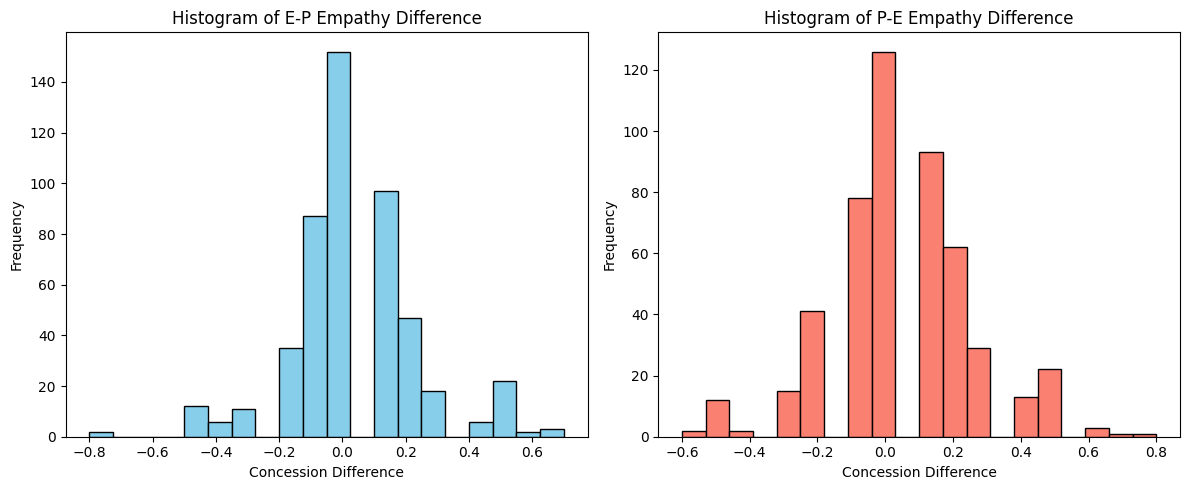

In [111]:
import matplotlib.pyplot as plt

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram 1
axes[0].hist(df_EP["concession_diff_adj"], bins=20, edgecolor='black', color='skyblue')
axes[0].set_title("Histogram of E-P Empathy Difference")
axes[0].set_xlabel("Concession Difference")
axes[0].set_ylabel("Frequency")

# Histogram 2
axes[1].hist(df_PE["concession_diff_adj"], bins=20, edgecolor='black', color='salmon')
axes[1].set_title("Histogram of P-E Empathy Difference")
axes[1].set_xlabel("Concession Difference")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


In [114]:
ttest_ind(df_EP['empathy_diff_adj'], df_PE['empathy_diff_adj'])[1]


np.float64(0.12003906419044166)

At its core, this diff_adj metric is independent of the model's own prediction; rather, it tells us about how well/which features capture human choice. 

We observe that PE has higher mean of difference (adj. by correct answer) across all four features. While these differences are statistically insignificant at alpha=0.05, there is still a story here:

But, is this due to magnitude of separation for a few pairs of responses or a greater frequency of positives? We observe that the number of positive rows in PE is higher across all four features, and the histograms reinforce the idea that P-E evaluates these features as higher for the correct response more CONFIDENTLY and FREQUENTLY. 

This is interesting too, considering the overall accuracy is pretty much the same. 

Now, we turn to logistic regression for  more rigorous interpretation. 


In [128]:
import statsmodels.api as sm

# X = df_EP[["empathy_diff_adj", "tone_similarity_diff_adj", "logic_diff_adj", "concession_diff_adj"]]
# X = sm.add_constant(X)
# y = df_EP["gpt_correct"]
# model = sm.Logit(y, X).fit()
# print(model.summary())

# X = df_PE[["empathy_diff_adj", "logic_diff_adj", "concession_diff_adj"]]
# X = sm.add_constant(X)
# y = df_PE["gpt_correct"]
# model = sm.Logit(y, X).fit_regularized()
# print(model.summary())


from statsmodels.iolib.summary2 import summary_col

# First model
X1 = sm.add_constant(df_EP[["empathy_diff_adj", "tone_similarity_diff_adj", "logic_diff_adj", "concession_diff_adj"]])
y1 = df_EP["gpt_correct"]
model1 = sm.Logit(y1, X1).fit()

# Second model
X2 = sm.add_constant(df_PE[["empathy_diff_adj", "tone_similarity_diff_adj", "concession_diff_adj"]])
y2 = df_PE["gpt_correct"]
model2 = sm.Logit(y2, X2).fit()

# Combine and display side-by-side
print(summary_col([model1, model2], stars=True, model_names=["EP", "PE"]))


Optimization terminated successfully.
         Current function value: 0.153912
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.185648
         Iterations 8

                             EP         PE    
----------------------------------------------
const                    0.5776***  0.8020*** 
                         (0.2127)   (0.2173)  
empathy_diff_adj         21.1886*** 6.3312*** 
                         (3.7270)   (1.5802)  
tone_similarity_diff_adj 11.3606*** 20.0960***
                         (2.4868)   (2.1943)  
logic_diff_adj           37.0756***           
                         (5.1778)             
concession_diff_adj      2.4460*    2.1107    
                         (1.2495)   (1.4187)  
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


I use a logistic regression model with four predictors (features) and dependent variable as whether GPT was correct; this allows us to determine a difference in which features help GPT out more accuracy-wise. 

Interpreting coefficient B1: a 1-unit increase in empathy (the correct response's empathy is an additional unit higher than that of the incorrect's) is associated with a log-odds increase in accuracy, or in other words, the probability of GPT matching the human's response to "which one is more persuasive?" But since the features were coded [0,1], interpreting actual increases is difficult. Instead, I choose to look at the relative importance between the predictors. 

I removed the logic predictor from PE because of collinearity; it gave me a single matrix error. 

Text(0.5, 1.0, 'Empathy difference when grouped by GPT accuracy')

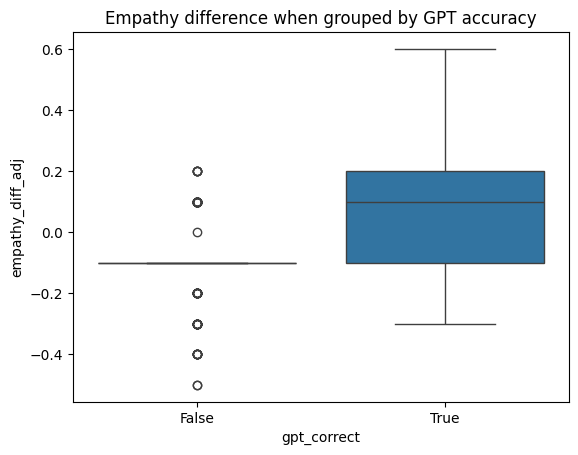

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(
    x="gpt_correct",
    y="empathy_diff_adj",
    data=df_EP
)
plt.title("Empathy difference when grouped by GPT accuracy")



By separating adjusted empathy difference (correct - incorreect), we are seeing that the group GPT predicted correctly had, on average, higher median difference in empathy. This makes sense: higher scores for correctly persuasive responses should be correlated with correct predictions. 

Identity salience and malleability. In theory, we'd expect negative correlation. 

In [135]:
ID_mall_EP = df_EP['identity_salience'].corr(df_EP['malleability'])
ID_mall_PE = df_PE['identity_salience'].corr(df_EP['malleability'])

print(f'ID-Malleability Correlation, EP: {ID_mall_EP} \nID-Malleability Correlation, PE: {ID_mall_PE}')

ID-Malleability Correlation, EP: 0.0029679848230656507 
ID-Malleability Correlation, PE: 0.04592712404099277


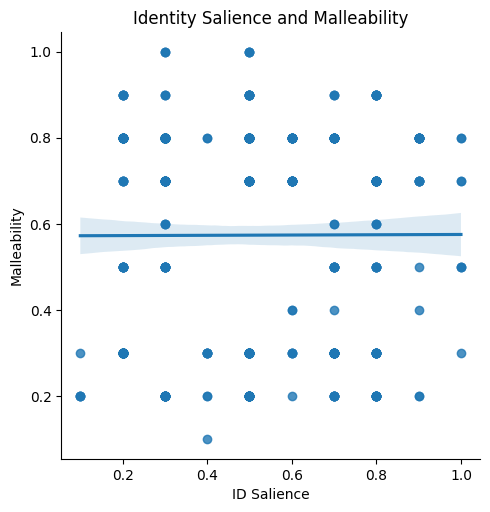

In [136]:
#sns.scatterplot(x='identity_salience', y='malleability', data=df_EP)
sns.lmplot(x='identity_salience', y='malleability', data=df_EP)
plt.title('Identity Salience and Malleability')
plt.xlabel('ID Salience')
plt.ylabel('Malleability')
plt.show()


Not as expected.

In [129]:
df_EP.columns

Index(['op', 'pos', 'neg', 'post_id', 'response_1', 'response_2', 'correct',
       'malleability', 'identity_salience', 'r1_tone_similarity',
       'r1_language_overlap', 'r1_empathy', 'r1_external_citation', 'r1_logic',
       'r1_identity_appeal', 'r1_politeness', 'r1_anecdote', 'r1_concession',
       'r2_tone_similarity', 'r2_language_overlap', 'r2_empathy',
       'r2_external_citation', 'r2_logic', 'r2_identity_appeal',
       'r2_politeness', 'r2_anecdote', 'r2_concession', 'more_persuasive',
       'pos_length', 'neg_length', 'gpt_predicted_length',
       'gpt_nonpredicted_length', 'gpt_correct', 'empathy_diff_adj',
       'tone_diff_adj', 'logic_diff_adj', 'concession_diff_adj',
       'length_diff_adj', 'tone_similarity_diff_adj'],
      dtype='object')

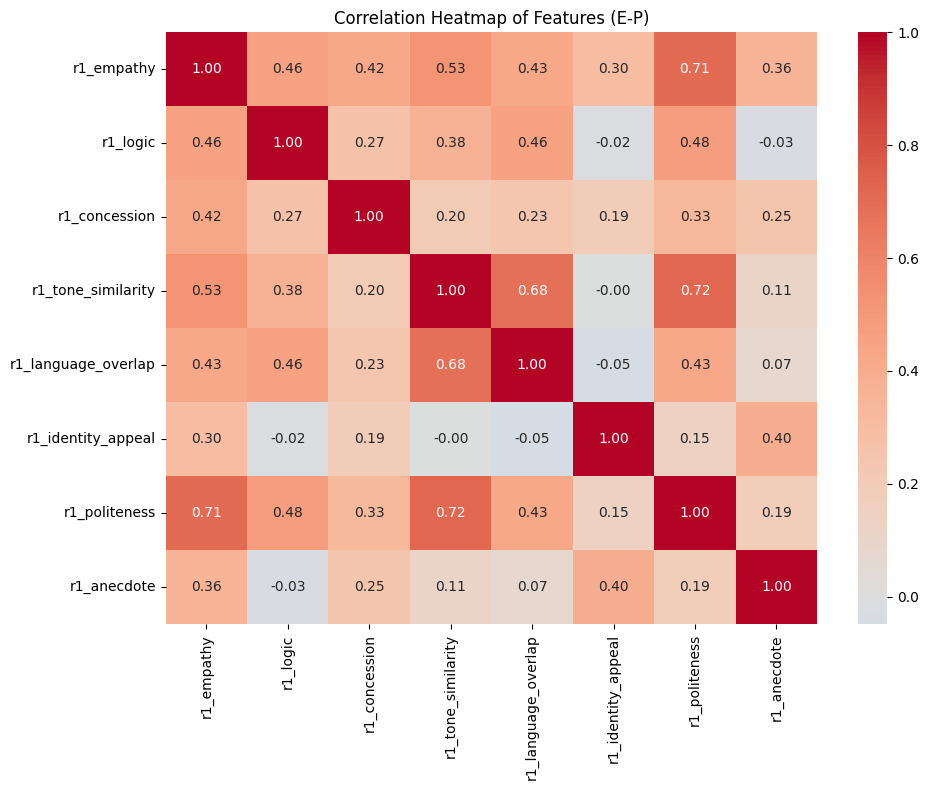

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select your relevant features
features = [
    "r1_empathy", "r1_logic", "r1_concession", "r1_tone_similarity", "r1_language_overlap",
    "r1_identity_appeal", "r1_politeness", "r1_anecdote"
]

# Compute correlation matrix
corr_matrix = df_EP[features].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation Heatmap of Features (E-P)")
plt.tight_layout()
plt.show()


Finally, are GPT's predictions in higher in all features than non-predictions? It helps us get an idea of how GPT weighs things. 

In [102]:
features = ["tone_similarity", "language_overlap", "empathy","external_citation", "logic", "identity_appeal", "politeness", "anecdote", "concession"]

# New DF for GPT predictions vs. non-predictions, to avoid cluttering df_EP
EP_predict_nonpredict = pd.DataFrame()
PE_predict_nonpredict = pd.DataFrame()

for feat in features:
    EP_predict_nonpredict[f"gpt_{feat}"] = np.where(
        df_EP["more_persuasive"] == "r1",
        df_EP[f"r1_{feat}"],
        df_EP[f"r2_{feat}"])
    
    EP_predict_nonpredict[f"non_gpt_{feat}"] = np.where(
        df_EP["more_persuasive"] == "r1",
        df_EP[f"r2_{feat}"],
        df_EP[f"r1_{feat}"])
    
    PE_predict_nonpredict[f"gpt_{feat}"] = np.where(
        df_PE["more_persuasive"] == "r1",
        df_PE[f"r1_{feat}"],
        df_PE[f"r2_{feat}"])
    
    PE_predict_nonpredict[f"non_gpt_{feat}"] = np.where(
        df_PE["more_persuasive"] == "r1",
        df_PE[f"r2_{feat}"],
        df_PE[f"r1_{feat}"])

melted_EP = pd.DataFrame()
melted_PE = pd.DataFrame()

for feat in features:
    df_feat = pd.DataFrame({
        "feature": feat,
        "source": ["GPT-chosen"] * len(EP_predict_nonpredict) + ["Not-chosen"] * len(EP_predict_nonpredict),
        "value": EP_predict_nonpredict[f"gpt_{feat}"].tolist() + EP_predict_nonpredict[f"non_gpt_{feat}"].tolist()
    })
    df_feat_2 = pd.DataFrame({
        "feature": feat,
        "source": ["GPT-chosen"] * len(PE_predict_nonpredict) + ["Not-chosen"] * len(PE_predict_nonpredict),
        "value": PE_predict_nonpredict[f"gpt_{feat}"].tolist() + PE_predict_nonpredict[f"non_gpt_{feat}"].tolist()
    })
    melted_EP = pd.concat([melted_EP, df_feat], ignore_index=True)
    melted_PE = pd.concat([melted_PE, df_feat_2], ignore_index=True)

/var/folders/ll/2pp9305j3zg3b9z2c3vf2ycr0000gp/T/ipykernel_36929/574878725.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
/var/folders/ll/2pp9305j3zg3b9z2c3vf2ycr0000gp/T/ipykernel_36929/574878725.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


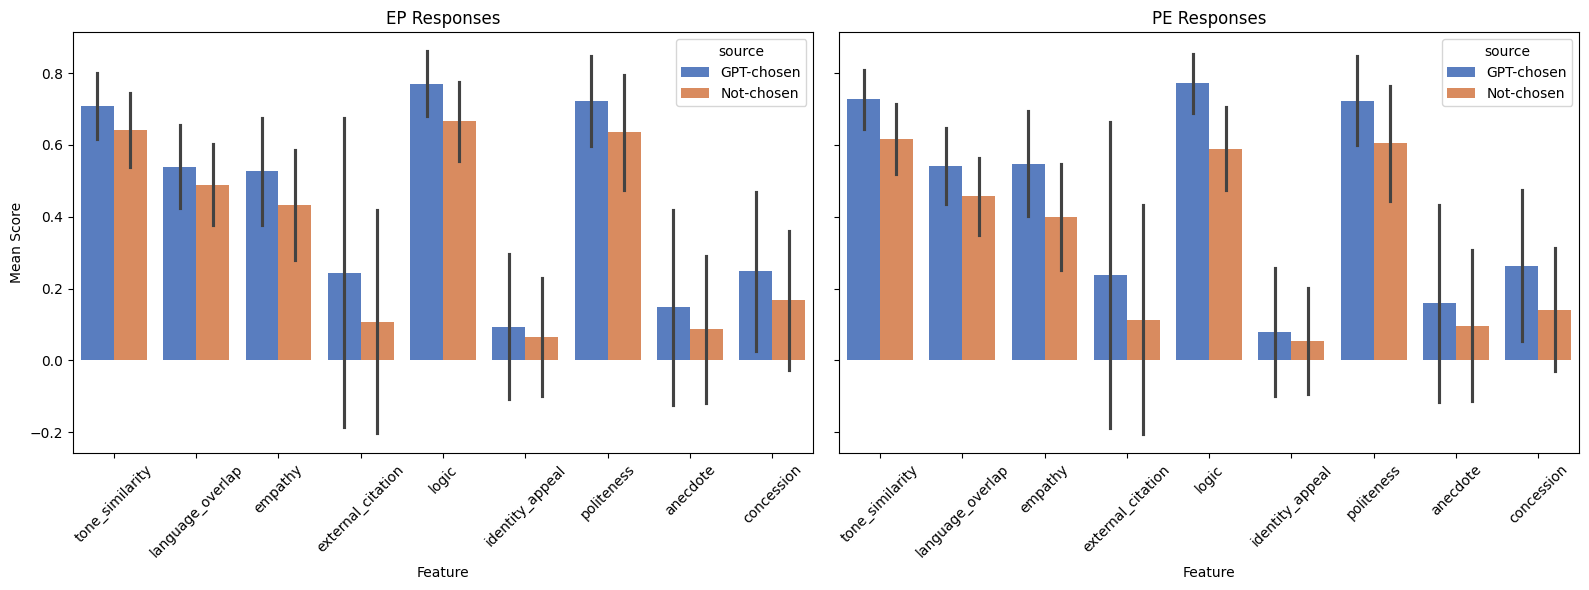

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Setup side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot EP
sns.barplot(
    data=melted_EP,
    x="feature",
    y="value",
    hue="source",
    ci="sd",
    palette="muted",
    ax=axs[0]
)
axs[0].set_title("EP Responses")
axs[0].set_ylabel("Mean Score")
axs[0].set_xlabel("Feature")
axs[0].tick_params(axis='x', rotation=45)

# Plot PE
sns.barplot(
    data=melted_PE,
    x="feature",
    y="value",
    hue="source",
    ci="sd",
    palette="muted",
    ax=axs[1]
)
axs[1].set_title("PE Responses")
axs[1].set_ylabel("")  # avoid duplicate y-axis label
axs[1].set_xlabel("Feature")
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

I choose to show all of these features separate from length (above) due to different scales. 